Final Project: Neutron Diffusion

FTCS 2D Neutron Diffusion

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def normal(x,y,sigma):
    return (np.exp(-(x*x+y*y)/(2*sigma*sigma)))/(sigma*np.sqrt(2*np.pi))

#physical constants
C = 1
D = 1
#lattice size constants
N=50
Nx=N
Ny=N

L=10

Tmax=15


#boundary condition type
boundType=1 #0 for value, 1 for derivative
schemeType=1 # 0 for FTCS, 1 for LAX



if schemeType == 0:
    schemeName="FTCS"
elif schemeType ==1:
    schemeName="LAX"

if boundType ==0:
    boundName = "Boundaries: $n(x,y,t) = 0$"
elif boundType ==1:
    boundName= "Boundaries: $\\frac{\partial n(x,y,t)}{\partial x, y} = 0$"


#Value based boundary conditions
if boundType == 0:
    x_ind=np.arange(Nx+2)# vector of 0 to Nx inclusive
    y_ind=np.arange(Ny+2)#vector of 0 to Nx inclusive
    hx=L/(Nx+1)
    hy=L/(Ny+1)
    x=-L/2 + x_ind*hx
    y=-L/2 + y_ind*hy
    boundval=0



# Derivative-based boundary conditions
if boundType == 1:
    x_ind=np.arange(Nx+2)# vector of 0 to Nx+1 inclusive
    y_ind=np.arange(Ny+2)#vector of 0 to Nx+1 inclusive
    hx=L/Nx
    hy=L/Ny
    x= -L/2 +(x_ind-1/2)*hx
    y= -L/2 +(y_ind-1/2)*hy
    #the value for the derivative on the boundaries is set to zero


#numerical scheme constants
tau = 0.01
if schemeType == 0:
    stabletau= hx*hy/(2*D)
elif schemeType ==1:
    stabletau=hx*hy/(2*D)
    #this is not the correct stability tau for LAX

if tau > stabletau:
    tau = stabletau*0.5
max_timestep=int(np.ceil(Tmax/tau))

# iterate 1 to Nx when loopin

grid=np.zeros((Nx+2,Ny+2))


Cgrid=np.ones((Nx+2,Ny+2))*C

#set up grid initial conditions
xp, yp = np.meshgrid(x, y)
grid=normal(xp,yp,1)

evolution=np.zeros((Nx+2,Ny+2,max_timestep))
evolution[:,:,0]=grid
if boundType ==0:
    grid[:,0]=boundval
    grid[:,-1]=boundval
    grid[0,:]=boundval
    grid[-1,:]=boundval
if boundType ==1:
    grid[:,0]=grid[:,1]
    grid[:,-1]=grid[:,-2]
    grid[0,:]=grid[1,:]
    grid[-1,:]=grid[-2,:]
    #the value for the derivative on the boundaries is set to zero
    evolution[:,:,0]=grid


for timestep in range(1,max_timestep):
 #update boundary values for record

    if schemeType == 0:
        #FTCS step
        grid[1:-1,1:-1]=grid[1:-1,1:-1]+D*tau*((grid[2:,1:-1]+grid[0:-2,1:-1]-2*grid[1:-1,1:-1])/(hx*hx)+(grid[1:-1,2:]+grid[1:-1,0:-2]-2*grid[1:-1,1:-1])/(hy*hy))+Cgrid[1:-1,1:-1]*tau*grid[1:-1,1:-1]
    elif schemeType == 1:
        laxavg=(grid[2:,1:-1]+grid[0:-2,1:-1]+grid[1:-1,2:]+grid[1:-1,0:-2])/4
        grid[1:-1,1:-1]=laxavg+D*tau*((grid[2:,1:-1]+grid[0:-2,1:-1]-2*laxavg)/(hx*hx)+(grid[1:-1,2:]+grid[1:-1,0:-2]-2*laxavg)/(hy*hy))+Cgrid[1:-1,1:-1]*tau*laxavg
        #lax step
    if boundType ==1:
        grid[:,0]=grid[:,1]
        grid[:,-1]=grid[:,-2]
        grid[0,:]=grid[1,:]
        grid[-1,:]=grid[-2,:]
        #the value for the derivative on the boundaries is set to zero
        #seems to be assigning by value rather than reference, which is good as by reference would break everything

    # by changing from a double loop over coordinates to an all-at-once matrix indexed option, a run went from 15.8 seconds to 0.266s
    # this was a transformation of i -> 1:-1, i+1 - > 2:, i-1 -> 0:-2
    #and the same for j
    evolution[:,:,timestep]=np.ndarray.copy(grid)

t= np.arange(max_timestep)*tau#create time indexing variable


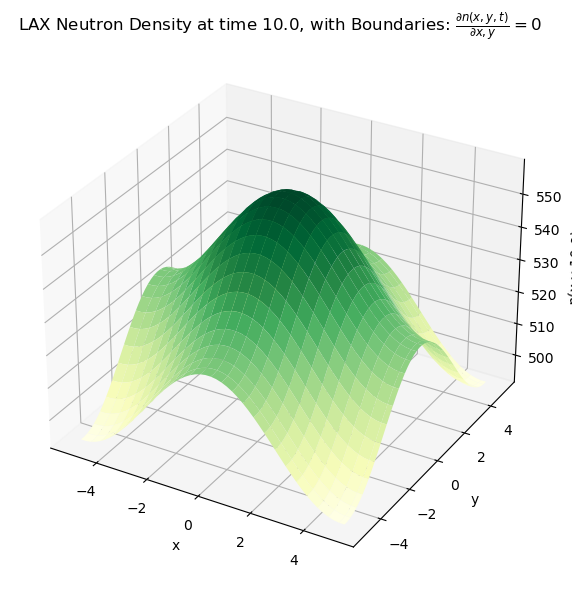

In [51]:
t_slice_index=1000

timeslice=t[t_slice_index]
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
xp, yp = np.meshgrid(x, y)

ax.plot_surface(xp, yp, evolution[:,:,t_slice_index], rstride=2, cstride=2, cmap='YlGn')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(f'n(x,y,{timeslice})')
plotitle=f'{schemeName} Neutron Density at time {timeslice}, with {boundName}'
ignore=ax.set_title(plotitle)
#ignore variable captures output that would otherwise get in the way

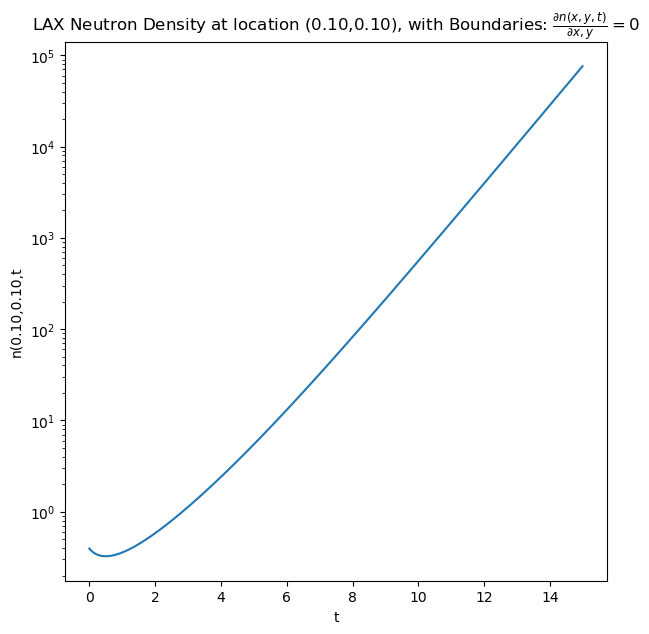

In [52]:
approx_center_index_x=int(np.ceil((Nx+2)/2))
approx_center_index_y=int(np.ceil((Ny+2)/2))

samplex=26
sampley=26

xval=x[samplex]
yval=y[sampley]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.semilogy(t,evolution[samplex,sampley,:])

ax.set_xlabel('t')
ax.set_ylabel(f'n({xval:.2f},{yval:.2f},t')
plotitle=f'{schemeName} Neutron Density at location ({xval:.2f},{yval:.2f}), with {boundName}'
ignore=ax.set_title(plotitle)

0.0 % done
0.0 % done
1.0 % done
2.0 % done
3.0 % done
4.0 % done
5.0 % done
6.0 % done
7.0 % done
8.0 % done
9.0 % done
10.0 % done
11.0 % done
12.0 % done
13.0 % done
14.0 % done
15.0 % done
16.0 % done
17.0 % done
18.0 % done
19.0 % done
20.0 % done
21.0 % done
22.0 % done
23.0 % done
24.0 % done
25.0 % done
26.0 % done
27.0 % done
28.0 % done
29.0 % done
30.0 % done
31.0 % done
32.0 % done
33.0 % done
34.0 % done
35.0 % done
36.0 % done
37.0 % done
38.0 % done
39.0 % done
40.0 % done
41.0 % done
42.0 % done
43.0 % done
44.0 % done
45.0 % done
46.0 % done
47.0 % done
48.0 % done
49.0 % done
50.0 % done
51.0 % done
52.0 % done
53.0 % done
54.0 % done
55.0 % done
56.0 % done
57.0 % done
58.0 % done
59.0 % done
60.0 % done
61.0 % done
62.0 % done
63.0 % done
64.0 % done
65.0 % done
66.0 % done
67.0 % done
68.0 % done
69.0 % done
70.0 % done
71.0 % done
72.0 % done
73.0 % done
74.0 % done
75.0 % done
76.0 % done
77.0 % done
78.0 % done
79.0 % done
80.0 % done
81.0 % done
82.0 % done
83.

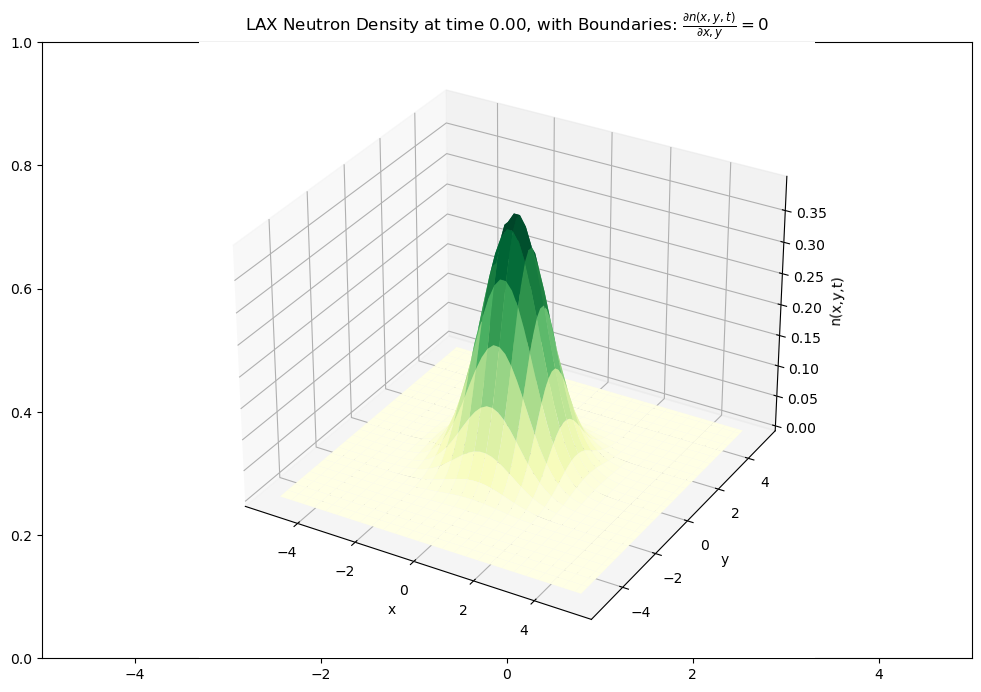

In [55]:
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(12,8))
ax.set(xlim=(-L/2,L/2))
ax = fig.add_subplot(projection='3d')

xp, yp = np.meshgrid(x, y)
curve=ax.plot_surface(xp, yp, evolution[:,:,0], rstride=2, cstride=2, cmap='YlGn')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(f'n(x,y,t)')

plotitle=f'{schemeName} Neutron Density at time {timeslice}, with {boundName}'
plt.title(plotitle)
#ignore variable captures output that would otherwise get in the way

stop_frame=10000000
actual_stop_frame=min(stop_frame,max_timestep)

def animateDiffusion(i):
    """ Helper function that sets the curve at a given frame i so that it can be rendered to video"""
    ax.clear()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(f'n(x,y,t)')
    curve=ax.plot_surface(xp, yp, evolution[:,:,i], rstride=2, cstride=2, cmap='YlGn')
    plt.title(f'{schemeName} Neutron Density at time {t[i]:.2f}, with {boundName}')
    if i % np.ceil(actual_stop_frame/100) == 0:
        print(f'{i/(actual_stop_frame)*100:.1f} % done')

    return curve



anim=animation.FuncAnimation(fig,animateDiffusion,interval=1000*tau,frames=actual_stop_frame)
anim.save(f'neutrons_t={tau}_T={max_timestep}_hx={hx}_L={L}_{schemeName}_bound={boundType}.mp4')

NameError: name 'xGrid' is not defined

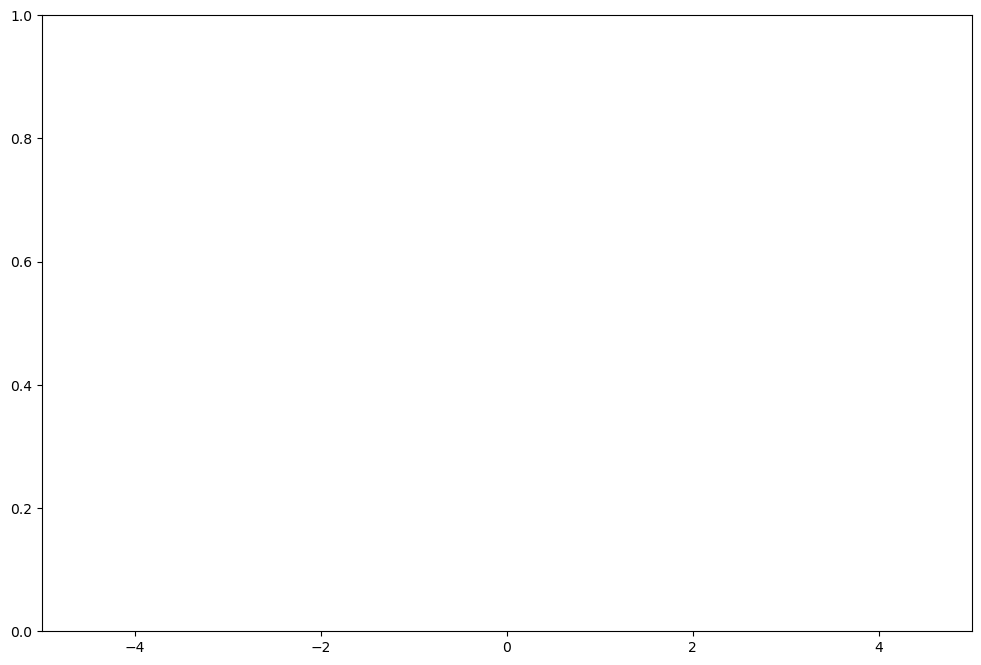

In [54]:
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(12,8))
ax.set(xlim=(-L/2,L/2))

curve=ax.plot(xGrid,grid[:,0])[0]

plt.xlabel("x")
plt.ylabel("$\\rho\,(x,t)$")
plt.grid(visible=True)
def animateKDV(i):
    """ Helper function that sets the curve at a given frame i so that it can be rendered to video"""
    plt.title(f"Soliton at t={i*tau:.2f}")
    curve.set_ydata(grid[:,i])

anim=animation.FuncAnimation(fig,animateKDV,interval=1000*tau,frames=min(tGridNum,blowupFrame+100))
anim.save(f'kdv_test_tau={tau}_T={maxTime}_xGridSize={xGridSize}_L={L}.mp4')

